# GA Capstone: Topic Modelling on Nvidia subreddit comments

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA modeling](#Prepare-reddit-comments-for-LDA-modeling)
- [Phrase modeling: Bigram and Trigram models](#Phrase-modeling:-Bigram-and-Trigram-models)
- [LDA Model Training](#LDA-Model-Training)
- [LDA Mallet Model](#LDA-Mallet-Model)
- Model creation
- Model Evaluation

# Import the libraries

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pprint import pprint
import os
from collections import Counter

# Bokeh package for TSNE
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook

import re
# NLTK Library
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.models import LdaMulticore, CoherenceModel, Phrases
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora

# pyLDAvis library
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

# Removes depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

# Load the dataset

In [4]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25511,motherboard say pcie 0 compatible,nvidia
25512,thanks understanding know course 3000s dvi por...,nvidia
25513,buy 1400 gpu,nvidia
25514,know ill wait 3070 3060,nvidia


In [5]:
nvidia_df = GPU_df[GPU_df['tag'] == 'nvidia']
nvidia_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25511,motherboard say pcie 0 compatible,nvidia
25512,thanks understanding know course 3000s dvi por...,nvidia
25513,buy 1400 gpu,nvidia
25514,know ill wait 3070 3060,nvidia


# Prepare comments for modeling

In [54]:
# Creates the bag of words for each document
data = [token.split() for token in nvidia_df['Reddit comments'].tolist()]

In [55]:
# Prints the bag of words from the first 3 documents
print(data[:3])

[['pre', 'order', 'time', 'releasing', '17th'], ['going', 'hard', 'grab', '3080', '17th'], ['uk', 'price', '3090', '1399', '3080', '649', '3070', '469', 'scan', 'aib', 'card', 'thanks', 'u', 'benzyl', 'chloride', 'overclockers', 'aib', 'card']]


# Phrase modeling: Bigram and Trigram models

In [56]:
# Build the bigram and trigram models
bigram = Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram, this reduces memory, making the model smaller and faster
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [57]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_bigrams = make_bigrams(data)

# Form Trigrams
data_trigrams = make_trigrams(data)

In [58]:
# Create a dictionary to hold the different n-grams dataset
phrase_list = {'unigram': data, 'bigrams': data_bigrams, 'trigrams': data_trigrams}
# phrase_list

# LDA on AMD comments with all the ngrams

In [83]:
# Creating a function to create the LDA model and compute the coherence score
def lda_calculate_coherence_values(ngram_data, num_topics):
    """
    This function calculates the coherence score and the perplexity scores for each ngram and stores
    the model, corpus and the id2word in their respective dictionaries
    """
    model_dict = {}
    score_dict = {}
    for key, value in ngram_data.items():
        ngram_id2word = corpora.Dictionary(value)
        ngram_corpus = [ngram_id2word.doc2bow(text) for text in value]

        ngram_lda_model = LdaMulticore(corpus=ngram_corpus, 
                             id2word=ngram_id2word, 
                             num_topics=num_topics,
                             chunksize=100,
                             passes=20, 
                             random_state=42,
                            per_word_topics=True)


        # Compute Perplexity score
        ngram_perplexity = ngram_lda_model.log_perplexity(ngram_corpus)  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=ngram_lda_model, texts=value, dictionary=ngram_id2word, coherence='c_v')
        ngram_coherence_lda = coherence_model_lda.get_coherence()
        
        # Prints out the topics for each ngram
        print('\n\n')
        print(f'*********Displaying {num_topics} topics for {key}******************\n\n')
        pprint(ngram_lda_model.print_topics())
        
        # Store the perplexity and coherence scores in score_dict
        score_dict[key] = []
        score_dict[key].append(ngram_perplexity)
        score_dict[key].append(ngram_coherence_lda)
        
        # Stores the ngram's model, corpus, id2word in model_dict
        model_dict[key] = []
        model_dict[key].append(ngram_lda_model)
        model_dict[key].append(ngram_corpus)
        model_dict[key].append(ngram_id2word)

    return score_dict, model_dict, num_topics

In [84]:
# Calculate using a dictionary
score_dict, model_dict, num_topics = lda_calculate_coherence_values(phrase_list, 5)




*********Displaying 5 topics for unigram******************


[(0,
  '0.019*"amd" + 0.019*"nvidia" + 0.011*"time" + 0.011*"people" + 0.009*"buy" '
  '+ 0.008*"3080" + 0.008*"year" + 0.007*"card" + 0.007*"know" + '
  '0.006*"price"'),
 (1,
  '0.014*"memory" + 0.012*"chip" + 0.009*"3090" + 0.009*"bit" + 0.007*"bus" + '
  '0.005*"video" + 0.004*"benchmark" + 0.004*"gaming" + 0.004*"number" + '
  '0.004*"marketing"'),
 (2,
  '0.013*"core" + 0.012*"3080" + 0.011*"power" + 0.011*"card" + 0.010*"psu" + '
  '0.009*"rtx" + 0.007*"fe" + 0.007*"fan" + 0.007*"case" + 0.007*"3090"'),
 (3,
  '0.022*"3080" + 0.019*"price" + 0.019*"3090" + 0.015*"ti" + 0.012*"people" + '
  '0.011*"card" + 0.009*"series" + 0.009*"2080" + 0.008*"going" + 0.008*"buy"'),
 (4,
  '0.029*"game" + 0.020*"vram" + 0.014*"4k" + 0.010*"1440p" + 0.008*"need" + '
  '0.008*"gpu" + 0.008*"setting" + 0.007*"play" + 0.007*"fps" + 0.007*"ram"')]



*********Displaying 5 topics for bigrams******************


[(0,
  '0.016*"price" + 0.

## Intrepreting the topics for unigram

Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () infers the score

Topic 0 (4)
* Discusses about the purchase of the GPUs

Topic 1 (3)
* Has to do with RTX 3090 and waiting on the GPU's benchmark

Topic 2 (2)
* 3080 and 3090 powersupply required to run the card, compares against fe (Founder's edition), reference cards and aib (AMD / Nvidia's 3rd party manufacturers like MSI, EVGA)

Topic 3 (3)
* The different types of GPUs

Topic 4 (2)
* Different resolutions for the monitor and the relationship with the GPU's video ram (vram)

**2 topics were intrepretable.**

## Interpreting the topics for the bigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (4)
* Discusses about the consumers waiting to upgrade their gpu

Topic 1 (2)
* Compares price against the 3090 and 3080 against the titan and 2080ti

Topic 2 (1)
* Has to do with 3080 and 3090's fan and psu

Topic 3 (2)
* gaming consoles and their cpu and gpu

Topic 4 (4)
* Different resolutions for the monitor to play the game

**2 topics were intrepretable.**

## Interpreting the topics for the trigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (4)
* Discusses about the consumers waiting to upgrade their gpu

Topic 1 (1)
* Fitting the GPU into their case (Possibly too big?)

Topic 2 (4)
* Different resolutions and the fps when playing games

Topic 3 (3)
* Different models of GPUs

Topic 4 (1)
* AMD and Nvidia's CPU and gpu price and power

**3 topics were intrepretable.**

In [79]:
topics_interpretable = [2,2,3]

In [80]:
score_df = pd.DataFrame(score_dict).T
score_df.columns = ['Perplexity score', 'Coherence score']
score_df['no of topics intrepretable'] = topics_interpretable
score_df

,Perplexity score,Coherence score,no of topics intrepretable
unigram,-7.831890,0.479104,2
bigrams,-7.889612,0.482577,2
trigrams,-7.875519,0.565147,3


## Summary

Using Coherence score as the main metric and no of topic intrepretable as the secondary metric to select the best ngram, between unigrams and bigrams, I'll be choosing **trigrams** as the it has the larger number of intrepretable topics compared to the other n_grams and it has the **second highest coherence score**.

## Visualizing the topics-keywords

In [92]:
# Obtaining the lda trigram model, corpus and dictionary
lda_trigram_model, trigram_corpus, trigram_id2word = model_dict['trigrams']

In [93]:
# Visualize the topics for the trigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'nvidia_' + 'trigram_' +'ldavis_prepared_'+str(num_topics))

trigram_vis = pyLDAvis.gensim.prepare(lda_trigram_model, trigram_corpus, trigram_id2word)

# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(trigram_vis, os.getcwd()+ '\\visualization\\' + 'nvidia_' + 'trigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')

trigram_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.088808  0.059652       1        1  26.598866
3     -0.001410  0.139206       2        1  22.717789
2      0.230121 -0.040339       3        1  21.672441
4     -0.053536  0.033069       4        1  17.320591
1     -0.086368 -0.191588       5        1  11.690313, topic_info=      Term         Freq        Total Category  logprob  loglift
295   game  1193.000000  1193.000000  Default  30.0000  30.0000
10    3090  1455.000000  1455.000000  Default  29.0000  29.0000
211   vram  1066.000000  1066.000000  Default  28.0000  28.0000
35      ti   817.000000   817.000000  Default  27.0000  27.0000
4     3080  1924.000000  1924.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
163    amd    77.969855   701.158808   Topic5  -5.4640  -0.0500
427   need    75.425762   613.325291   Topic5  -5.4972   0.0507
389   know    70.793212   639.285214   Topic5  -5.5606  -0.0542
73     new    64.949701   773.085113   Topic5  -5.6468  -0.3304
280  think    63.387011   783.481893   Topic5  -5.6711  -0.3681

[371 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
92        3  0.891624     0
92        4  0.101729     0
92        5  0.005984     0
194       1  0.130186    10
194       2  0.466249    10
...     ...       ...   ...
227       1  0.579740  year
227       2  0.057364  year
227       3  0.247763  year
227       4  0.073230  year
227       5  0.041497  year

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

## Intrepeting the pyLDAvis graph

Topics 1 has the largest bubble which shows the larger percentage of the documents belong to topic 1. Topics 1 and 4 overlap one another, which shows that they have close related to one another. Topic 5 is the furtherest apart from the other topics. The blue bars represent the overall term frequency of the corpus and the red bars represent the term frequency with regards to the topic.

The GPU model terms tend to appear the most often in topic 3. Topic 2 discusses about the different types of resolutions. Topic 4 mainly discusses amd and nividia and amd's CPU and GPU power. Topic 5 discusses about the rtx 3080 and rtx 3090 size and how it fits in their computer casing.

# LDA Mallet Model

Notes:

* Download [link](http://mallet.cs.umass.edu/download.php)
* Need to install [JDK](https://www.oracle.com/java/technologies/javase-jdk15-downloads.html) (Java Development Kit) to make it work
* Need to configure the [PATH file](https://docs.oracle.com/javase/10/install/installation-jdk-and-jre-microsoft-windows-platforms.htm#JSJIG-GUID-96EB3876-8C7A-4A25-9F3A-A2983FEC016A) after installing

Go to *Importing the optimal mallet model pickle file* section if you've not installed the JDK

LDA Mallet model often gives a better quality of topics compared to the LDA. I'll be creating to see if the coherence score is much greater than the LDA and if there's a greater intrepretability in the number of topics.

In [19]:
# Update the environment path
os.environ.update({'MALLET_HOME': r'C:\mallet\mallet-2.0.8'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'
# prefix_path = r'C:/mallet/ga_capstone'
mallet_path

'C:/mallet/mallet-2.0.8/bin/mallet.bat'

## Finding the best k topics for the mallet model

In [20]:
# Solution: Follow this
def mallet_compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    num_topics_list: Number of topics
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    #For two lines below update with your path to new_mallet
#     os.environ.update({'MALLET_HOME':r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8'})
#     mallet_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8\bin\mallet.bat'
#     prefix_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet files'
    
    coherence_values = []
    model_list = []
    num_topics_list = []


    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary, random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    return model_list, coherence_values, num_topics_list

In [21]:
# Using Bigram as it has the highest coherence value
model_list, coherence_values, num_topics_list = mallet_compute_coherence_values(dictionary=trigram_id2word, all_corpus=trigram_corpus,
                                                                         texts=data_trigrams, start=1, limit=11, step=1)

# Creating the dataframe to hold the model list, coherence values and the number of topics list
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

# Finds the optimal number of topics based on the highest coherence score
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

# Train the model based on the optimal number of topics
optimal_model = LdaMallet(mallet_path, corpus=trigram_corpus, num_topics=optimal_num_topics, id2word=trigram_id2word,
                                                 prefix='nvidia_optimal_', random_seed=42)

In [22]:
model_values_df

,model_list,coherence_values,num_topics
0,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.371841,1
1,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.533103,2
2,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.569926,3
3,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.536058,4
4,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.535934,5
5,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.536693,6
6,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.538344,7
7,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.519279,8
8,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.508902,9
9,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.482650,10


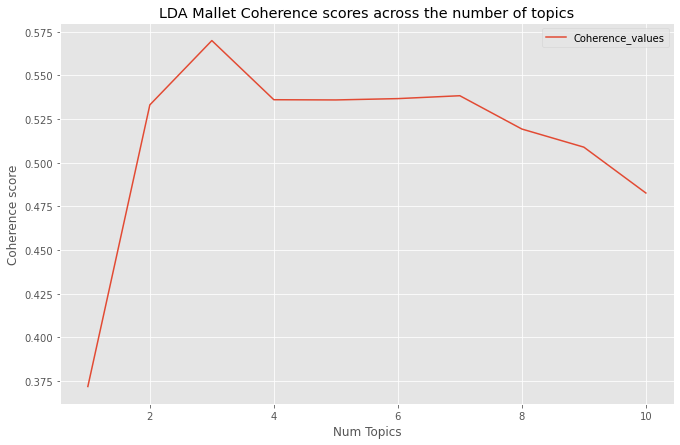

In [91]:
# model_list, coherence_values = compute_coherence_values(dictionary=trigram_id2word, corpus=trigram_corpus, texts=data_trigrams, start=start, limit=limit, step=step)

# Show graph

x = model_values_df['num_topics'].values.tolist()

plt.figure(figsize=(11,7))

plt.plot(x, coherence_values)

plt.title('LDA Mallet Coherence scores across the number of topics')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence_values"], loc='best')
plt.show()

The coherence score peaks at creating 3 topics before it starts to stagnate and dip. 

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3718
Num Topics = 2  has Coherence Value of 0.5331
Num Topics = 3  has Coherence Value of 0.5699
Num Topics = 4  has Coherence Value of 0.5361
Num Topics = 5  has Coherence Value of 0.5359
Num Topics = 6  has Coherence Value of 0.5367
Num Topics = 7  has Coherence Value of 0.5383
Num Topics = 8  has Coherence Value of 0.5193
Num Topics = 9  has Coherence Value of 0.5089
Num Topics = 10  has Coherence Value of 0.4826


Viewing the topics and checking if they make sense helps to decide how many topics is the optimal value. I'll be intrepreting the 3 and 4th topic.

## Exporting the optimal model to pickle file

In [25]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/nvidia_optimal_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(optimal_model, out_file)
out_file.close()

## Exporting the 2 topics trained model to pickle file

In [86]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/nvidia_2_topics_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(model_values_df['model_list'][1], out_file)
out_file.close()

## Importing the optimal mallet model pickle file

In [27]:
# pkl_filename = "./models/nvidia_optimal_ldamallet_model.pkl"
# infile = open(pkl_filename,'rb')
# optimal_model = pickle.load(infile)
# infile.close()

In [28]:
# optimal_model

## Importing the 2 topics mallet model pickle file

In [89]:
pkl_filename = "./models/nvidia_2_topics_ldamallet_model.pkl"
infile = open(pkl_filename,'rb')
topic_2_ldamallet = pickle.load(infile)
infile.close()

In [30]:
# topic_5_ldamallet 

## Displaying topics for the optimal model (3 topics)

In [85]:
pprint(optimal_model.show_topics(formatted=False))

[(0,
  [('3080', 0.04898901098901099),
   ('3090', 0.03637362637362637),
   ('ti', 0.01876923076923077),
   ('amd', 0.01567032967032967),
   ('3070', 0.015274725274725275),
   ('rtx', 0.014351648351648351),
   ('2080', 0.012153846153846154),
   ('upgrade', 0.011604395604395605),
   ('2080ti', 0.01123076923076923),
   ('wait', 0.01120879120879121)]),
 (1,
  [('price', 0.026140252089920733),
   ('card', 0.026096937670550525),
   ('nvidia', 0.0249274483475549),
   ('people', 0.02434270368605709),
   ('time', 0.01890674405509594),
   ('buy', 0.01728245332871313),
   ('money', 0.009009399229003335),
   ('series', 0.008814484341837398),
   ('release', 0.008597912244986357),
   ('day', 0.008013167583488544)]),
 (2,
  [('game', 0.02716178979136596),
   ('vram', 0.023662686436600622),
   ('gpu', 0.014390062546472467),
   ('4k', 0.01325285395617373),
   ('year', 0.010737873419936142),
   ('1440p', 0.010562918252197875),
   ('gaming', 0.010453571272361458),
   ('good', 0.01034422429252504),
   ('

## Interpreting the 3 topics 

Topic 0
* Different models of GPU

Topic 1
* Price related during GPU launch day

Topic 2
* Different resolutions: 1440p, 4K being played

## Displaying 2 topics

In [90]:
pprint(topic_2_ldamallet.show_topics(formatted=False))

[(0,
  [('3080', 0.0321826135920648),
   ('3090', 0.023895121352564934),
   ('game', 0.017932169619266254),
   ('vram', 0.015622067252855143),
   ('ti', 0.012330171380719308),
   ('gpu', 0.010843042982342154),
   ('3070', 0.010034507154098265),
   ('rtx', 0.00942810528291535),
   ('4k', 0.008749512712782084),
   ('2080', 0.007984291303908405)]),
 (1,
  [('price', 0.017713790927369053),
   ('card', 0.01768443916112652),
   ('nvidia', 0.016891941472578113),
   ('people', 0.016495692628303908),
   ('time', 0.012812045964865936),
   ('buy', 0.011711354730770925),
   ('amd', 0.010463904665463245),
   ('good', 0.009480620496338367),
   ('wait', 0.009260482249519366),
   ('money', 0.0062812779759022)])]


## Interpreting the 2 topics 

Topic 0
* Different gpu models

Topic 1
* Stock availability

As I find the **3 topics** to be the most intrepretable as well as it's one of the highest coherence score among the other models, I'll be selecting to it to move forward with the project.

## Creating tags for the dominant topics

In [188]:
dominant_topic_to_tag = {0.0:'gpu model', 1.0:'price launch', 2.0:'resolution/game'}
df_dominant_topic['Tag'] = df_dominant_topic['Dominant_Topic'].map(lambda x:dominant_topic_to_tag.get(x))
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document,Tag
0,0,1.0,0.3827,"price, card, nvidia, people, time, buy, money,...","[pre_order, time, releasing, 17th]",price launch
1,1,1.0,0.3642,"price, card, nvidia, people, time, buy, money,...","[going, hard, grab, 3080, 17th]",price launch
2,2,1.0,0.4343,"price, card, nvidia, people, time, buy, money,...","[uk, price, 3090, 1399, 3080, 649, 3070, 469, ...",price launch
3,3,0.0,0.3457,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[talking, spatula, jensen, pot]",gpu model
4,4,0.0,0.3395,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[10k, core, completely, insane]",gpu model
...,...,...,...,...,...,...
10985,10985,0.0,0.3642,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[motherboard, say, pcie, 0, compatible]",gpu model
10986,10986,0.0,0.4273,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[thanks, understanding, know, course, 3000s, d...",gpu model
10987,10987,0.0,0.3396,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[buy, 1400, gpu]",gpu model
10988,10988,0.0,0.3395,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[know, ill, wait, 3070, 3060]",gpu model


# Finding the dominant topic in each sentence

I would like to investigate the dominant topics for the documents and see if it makes sense.

In [94]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for _, row in enumerate(ldamodel[corpus]): # ldamodel[corpus] --> Provides a list of the probability values of which topic a document belongs to
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # Sorts the probabilities of a document is descending order
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic (As it's sorted in descending order, the highest probability is the first topic which is index 0)
                wp = ldamodel.show_topic(topic_num) # Obtain the dominant topic for the document
                topic_keywords = ", ".join([word for word, prop in wp]) # Gets the topic keys words for the topic
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

Notes: The last model trained **must match** with the last optimal_file_doctopics text file. If not, there will be an error message.

In [34]:
# Retrain the model if you've have not done so
# optimal_num_topics = 6
# optimal_model = LdaMallet(mallet_path, corpus=trigram_corpus, num_topics=optimal_num_topics, id2word=trigram_id2word,
#                                                  prefix='optimal_', random_seed=42)

In [95]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=trigram_corpus, texts=data_trigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,1.0,0.3827,"price, card, nvidia, people, time, buy, money,...","[pre_order, time, releasing, 17th]"
1,1,1.0,0.3642,"price, card, nvidia, people, time, buy, money,...","[going, hard, grab, 3080, 17th]"
2,2,1.0,0.4343,"price, card, nvidia, people, time, buy, money,...","[uk, price, 3090, 1399, 3080, 649, 3070, 469, ..."
3,3,0.0,0.3457,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[talking, spatula, jensen, pot]"
4,4,0.0,0.3395,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[10k, core, completely, insane]"
5,5,0.0,0.3512,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[rip, 2080, ti, resale_value, x200b, cry]"
6,6,0.0,0.4159,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[shit, 3070, actually, better, value, people, ..."
7,7,1.0,0.3568,"price, card, nvidia, people, time, buy, money,...","[send, money]"
8,8,0.0,0.4740,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[question, nvidia, 3xxx, series, page, reporti..."
9,9,0.0,0.3690,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[3070, perform, better, 2080ti, price, holy, f..."


In [154]:
# Sort the dataframe in ascending order by the topic percentage contribution
df_dominant_topic_sorted = df_dominant_topic.sort_values('Topic_Perc_Contrib', ascending=False)
idx = np.random.randint(df_dominant_topic_sorted.shape[0])
# idx = 250
document = df_dominant_topic_sorted[['Document']].iloc[idx].values
dominant_topic = df_dominant_topic_sorted[['Dominant_Topic']].iloc[idx].values
dominant_keywords = df_dominant_topic_sorted[['Keywords']].iloc[idx].values

In [155]:
print(f'Dominant keywords: {dominant_keywords} \n\nDocument:{document}')

Dominant keywords: ['3080, 3090, ti, amd, 3070, rtx, 2080, upgrade, 2080ti, wait'] 

Document:[list(['bracing', '500', 'dollar', 'hey', 'new', 'tech', 'im', 'seeing', '600', 'artificially', 'gimped', 'thanks', 'ill', 'stick', '970', 'little', 'longer', 'hope', 'big_navi', 'compete', 'think', 'lower', 'price', 'point'])]


The document talks about the user waiting for a lower price point as the user finds the of the GPU to be too expensive.

# Find the most representative document for each topic

In [103]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format the columns
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6234,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[3090, simply, titan, titan, driver, basically..."
1,1.0,0.7326,"price, card, nvidia, people, time, buy, money,...","[edit, opinion, x200b, know, teaser_rate, car,..."
2,2.0,0.6444,"game, vram, gpu, 4k, year, 1440p, gaming, good...","[plenty, depends, singeplayer, multiplayer, ba..."


In [173]:
def show_topics(dominant_topic, index):
    """
    Shows the document of the dominant topic
    """
    print(" ".join(df_dominant_topic[df_dominant_topic['Dominant_Topic'] == dominant_topic].sort_values('Topic_Perc_Contrib', ascending=False).head().iloc[index]['Document']))

## Most representative document for Topic 0

In [104]:
# Create a helper function to display the most representative documents for a topic
def display_representative_document(topic_n, df):
    dominant_keywords = df['Keywords'].loc[topic_n]
    document_topic = " ".join(df['Representative Text'].loc[topic_n])
    
    print(f'*******Topic {topic_n}********\n\nDominant keywords: {dominant_keywords} \n\nDocument:{document_topic}')

In [105]:
display_representative_document(0, sent_topics_sorteddf_mallet)

*******Topic 0********

Dominant keywords: 3080, 3090, ti, amd, 3070, rtx, 2080, upgrade, 2080ti, wait 

Document:3090 simply titan titan driver basically titan mind 2080 ti increase vram 1080 ti previous gen doubled respectively x70 class 8gb 1070 previously doubling gen prior 28gb 570 2gb 670 2gb 770 680 rebrand 4gb 970 8gb 1070 staying 8gb similarly x80 class doubled gen staying 8gb 1080 2080 receiving minor capacity upgrade 10gb 3080 supposed believe 10gb 3080 upgrade path 11gb 2080 ti compute 3090 titan driver actual titan


The document talks about the different types of GPUs which fits the topic.

## Most representative document for Topic 1

In [106]:
display_representative_document(1, sent_topics_sorteddf_mallet)

*******Topic 1********

Dominant keywords: price, card, nvidia, people, time, buy, money, series, release, day 

Document:edit opinion x200b know teaser_rate car advertised insanely price dealership told sold cost little 699 3080 teaser_rate nvidia hyped insanely hint 3080 wanted insanely cheap price announced wanted problem nvidia stock 3080 place retailer stock place know run merchandise tracking system retailer nvidia hype knowing stock satisfy basic demand release day come nvidia counted bot ebay taking 3080 actually available blame bot nvidia overselling hype delivering card bot responsible retailer nvidia hype train knew sufficient stock satisfy basic demand retailer scam seriously believe retailer know stock send 14 99 deliver moon someday guarantee 1000 year offer valid entire universe send money backlash swift betting nvidia shat pant reading forum pissed consumer oh look pre_order delivery october november soon december year nvidia placate consumer come hey worse ussr ordered

The document talks about the 3080 gpu price which fits the topic.

## Most representative document for Topic 2

In [107]:
display_representative_document(2, sent_topics_sorteddf_mallet)

*******Topic 2********

Dominant keywords: game, vram, gpu, 4k, year, 1440p, gaming, good, high, pc 

Document:plenty depends singeplayer multiplayer battle royale dog obviously apex legend br duty sp mp br battlefield sp mp br counterstrike mp pubg br doom sp mp rainbow 6 siege mp wolfenstein sp mp fortnite br outlier borderland looter shooter warframe space ninja looter shooter ton grind left dead want shoot zombie deep rock galactic coop experience hardcore simulation shooter arma squad insurgency


The document talks about the different types of games which partially fits the topic but does not mention the resolutions, `1440p`, `4k` or `vram`.

# Topic distribution across documents

In [109]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num = pd.Series(sorted(df_topic_sents_keywords['Dominant_Topic'].unique()))
topic_keywords = sent_topics_sorteddf_mallet['Keywords']

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num, topic_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(6)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...",4182,0.3805
1.0,1.0,"price, card, nvidia, people, time, buy, money,...",3804,0.3461
2.0,2.0,"game, vram, gpu, 4k, year, 1440p, gaming, good...",3004,0.2733


In [110]:
# Sort the Percentage of documents in descending order
df_dominant_topics.sort_values(by='Perc_Documents', ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...",4182,0.3805
1.0,1.0,"price, card, nvidia, people, time, buy, money,...",3804,0.3461
2.0,2.0,"game, vram, gpu, 4k, year, 1440p, gaming, good...",3004,0.2733


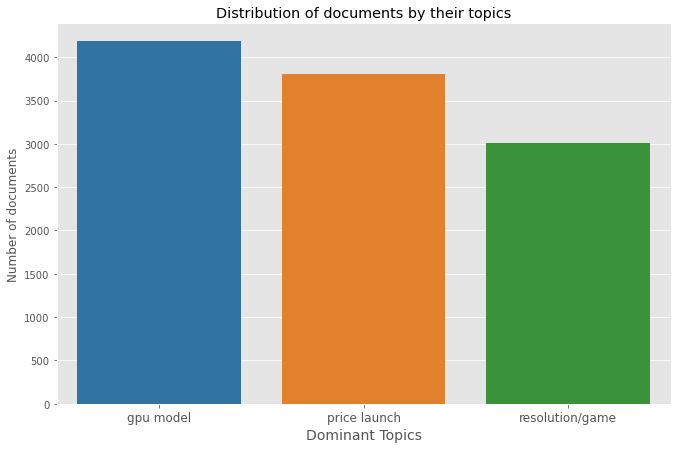

In [198]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

plt.figure(figsize=(11,7))
sns.barplot(x='Dominant_Topic', y='Num_Documents',data=df_dominant_topics, palette=cols)

plt.title('Distribution of documents by their topics')
plt.xticks(np.arange(3),list(dominant_topic_to_tag.values()), fontsize=12)
plt.xlabel('Dominant Topics', fontsize=14)
plt.ylabel('Number of documents');

Topic `gpu model` has the most documents compared to other topics like `price launch` and the `resolution/game`.

# Frequency Distribution of Word Counts in Documents by dominant topic

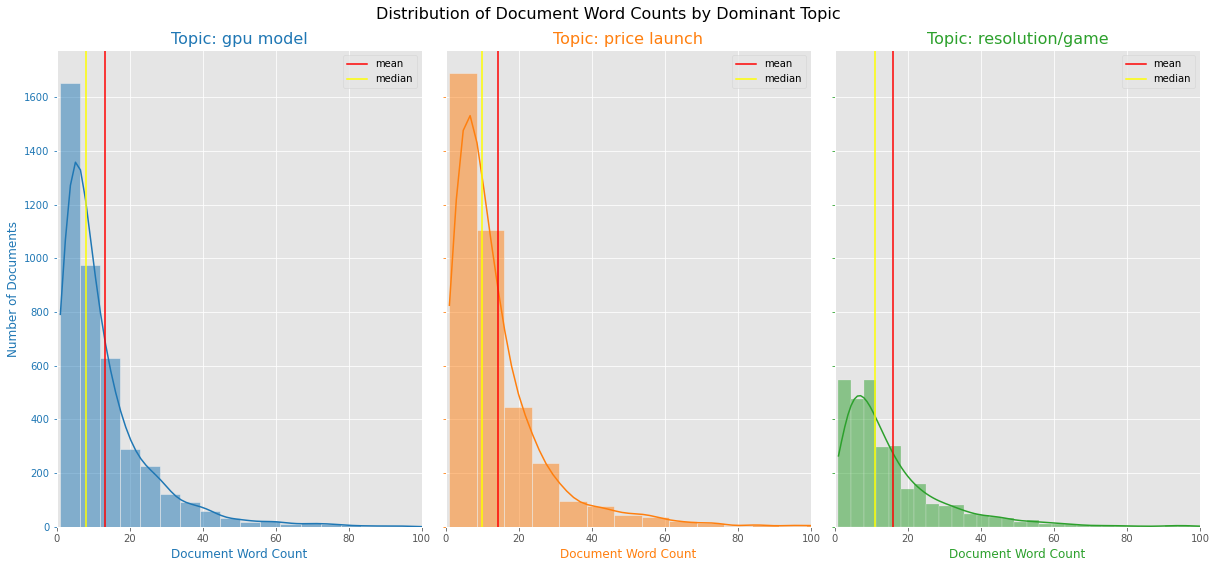

In [204]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(1,3, figsize=(17,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i]
    doc_lens = df_dominant_topic_sub.Document.map(lambda token: len(token)).tolist()
    #ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.histplot(doc_lens, bins=50, color=cols[i], kde=True, ax=ax) # ax.twinx()
    # Mean
    ax.axvline(np.mean(doc_lens), color='red', label='mean')
    # Median
    ax.axvline(np.median(doc_lens), color='yellow', label='median')
    ax.legend()
    ax.set_xlabel('Document Word Count', color=cols[i])
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+ str(dominant_topic_to_tag.get(i)), fontdict=dict(size=16, color=cols[i]))

# fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,375,9))
plt.xlim(0,100)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.tight_layout()
plt.show()

All of the distributions shows a right tailed skewed graph in which the mean and median are quite close. In `resolution/game`, it has a smaller number of documents compared to the other documents. 

# Word Clouds of Top N Keywords in Each Topic

In [134]:
stop_words = set(STOPWORDS).union(stopwords.words("english")) # Combines gensim stopwords and nltk's stopwords
stop_words = stop_words.union(['http', 'www', 'youtube' 'get', 'like', '1', '2', '3', '5', 'got'])

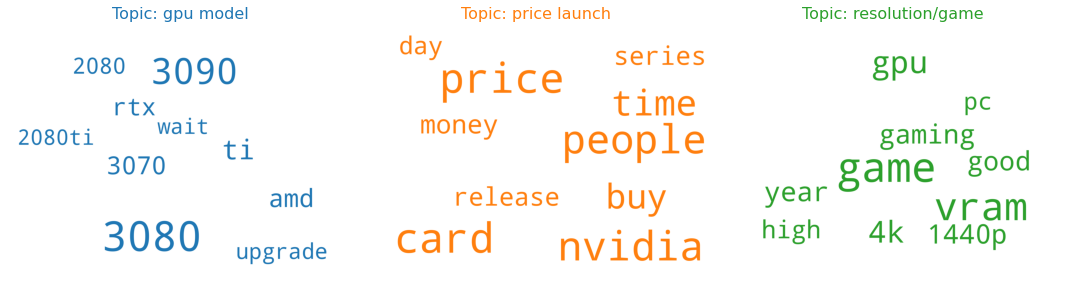

In [205]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic: ' + str(dominant_topic_to_tag.get(i)), fontdict=dict(size=16), color=cols[i])
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

In [137]:
data_flat = [word for word_lst in data_trigrams for word in word_lst] # Creates a list of words 
counter = Counter(data_flat) # Counts the frequency of the tokens and stores in a dictionary
counter

Counter({'pre_order': 58,
         'time': 873,
         'releasing': 48,
         '17th': 61,
         'going': 879,
         'hard': 167,
         'grab': 36,
         '3080': 2229,
         'uk': 63,
         'price': 1208,
         '3090': 1655,
         '1399': 11,
         '649': 12,
         '3070': 695,
         '469': 3,
         'scan': 24,
         'aib': 195,
         'card': 1205,
         'thanks': 184,
         'u': 53,
         'benzyl': 1,
         'chloride': 1,
         'overclockers': 16,
         'talking': 134,
         'spatula': 3,
         'jensen': 32,
         'pot': 1,
         '10k': 18,
         'core': 165,
         'completely': 63,
         'insane': 80,
         'rip': 27,
         '2080': 553,
         'ti': 854,
         'resale_value': 8,
         'x200b': 91,
         'cry': 24,
         'shit': 190,
         'actually': 427,
         'better': 633,
         'value': 158,
         'people': 1124,
         'expected': 47,
         'expensive': 144,


In [138]:
out = [[word, i , weight, counter[word]] for i, topic in topics for word, weight in topic]
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.head()

,word,topic_id,importance,word_count
0,3080,0,0.048989,2229
1,3090,0,0.036374,1655
2,ti,0,0.018769,854
3,amd,0,0.015670,713
4,3070,0,0.015275,695


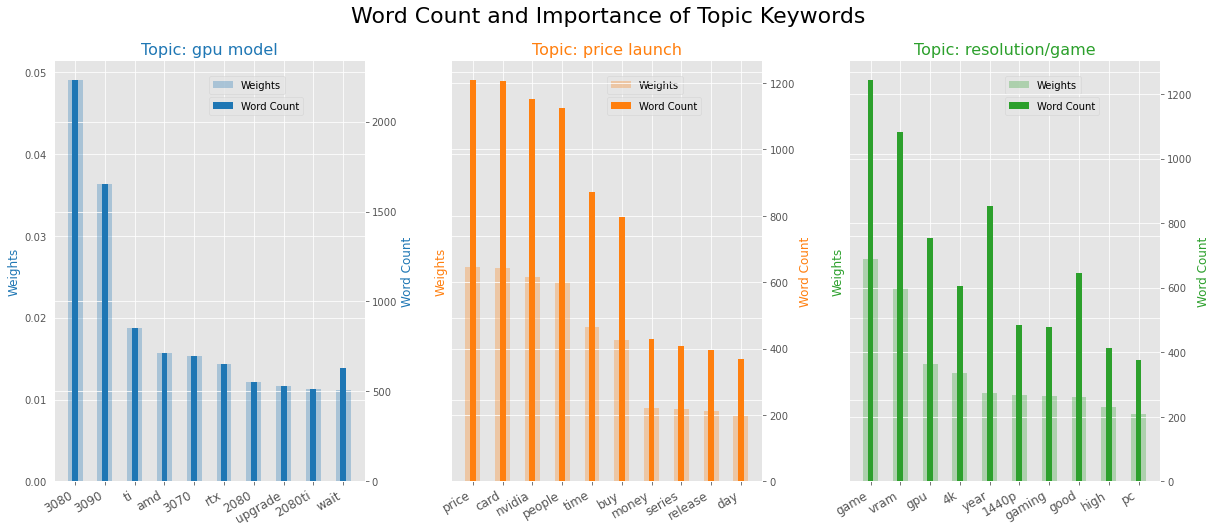

In [213]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 3, figsize=(17,7), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Weights')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Word Count')
    ax.set_ylabel('Weights', color=cols[i])
    ax_twin.set_ylabel('Word Count', color=cols[i])
    # Sets the ylimits for the axes
    #ax_twin.set_ylim(0, 0.030)
    #ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(dominant_topic_to_tag.get(i)), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'].tolist(), rotation=30, horizontalalignment= 'right', fontsize=12)
    ax_twin.legend(loc=[0.50,0.87])
    ax.legend(loc=[0.50,0.92])
    

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Intrepreting the topic word frequency and their weights

Topic gpu model:
* The topic weights and the word count are match up to one another
* The 3080 and 3090 are popular GPUs given their high word count and weight

Topic price launch:
* Unlike the keywords in topic gpu model, the word count exceed that of the topic weights assigned which highlights the redundancy of some of the keywords
* It looks like the topics weights are about of half the word count.
* Mostly relates to the purchase of the GPUs on release day

Topic resolution/game:
* Gaming on 4k resolution to be most talked compared to gaming on 1440p resolution as seen in the word count and the topic weight
* vram plays a critical role in the resolution as generally the higher the resolution the more vram a game consumes

# t-SNE Clustering Chart

In [147]:
# Get topic weights
topic_weights = []

for row_lst in optimal_model[trigram_corpus]:
    lst = []
    for topic_id, topic_perc in row_lst:
        lst.append(topic_perc)
    topic_weights.append(lst)
    

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=30, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
lgd_label = np.array(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])

source = ColumnDataSource(dict(
    x=tsne_lda[:,0],
    y=tsne_lda[:,1],
    color=mycolors[topic_num],
    label=lgd_label[topic_num],
))

plot.scatter(x='x', y='y', color='color', source=source)
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8559 samples in 0.007s...
[t-SNE] Computed neighbors for 8559 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8559
[t-SNE] Computed conditional probabilities for sample 2000 / 8559
[t-SNE] Computed conditional probabilities for sample 3000 / 8559
[t-SNE] Computed conditional probabilities for sample 4000 / 8559
[t-SNE] Computed conditional probabilities for sample 5000 / 8559
[t-SNE] Computed conditional probabilities for sample 6000 / 8559
[t-SNE] Computed conditional probabilities for sample 7000 / 8559
[t-SNE] Computed conditional probabilities for sample 8000 / 8559
[t-SNE] Computed conditional probabilities for sample 8559 / 8559
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.555557
[t-SNE] KL divergence after 1000 iterations: 0.696648


Loading BokehJS ...

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised non-linear learning technique used for data exploration and visualizing higher dimensional data. It gives a sense of how the data is arranged in a high dimensional-space. In here, the t-SNE model is trained on the topic weights and plotted as seen in the above. As t-SNE preserves small pairwise compared to Principal Component Analysis (PCA), we can see that the dots don't overlap one another.

# pyLDAVis

In [214]:
# Visualize the topics for the trigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'nvidia_' + 'trigram_' +'mallet_ldavis_prepared_'+str(num_topics))

optimal_model_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
trigram_mallet_vis = pyLDAvis.gensim.prepare(optimal_model_lda, trigram_corpus, trigram_id2word)

# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(trigram_mallet_vis, os.getcwd()+ '\\visualization\\' + 'nvidia_' + 'trigram_' + 'mallet_ldavis_prepared_'+ str(num_topics) +'.html')
trigram_mallet_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.099948 -0.365020       1        1  33.622151
1     -0.275786  0.266505       2        1  33.374003
0      0.375734  0.098515       3        1  33.003846, topic_info=       Term         Freq        Total Category  logprob  loglift
4      3080  2545.000000  2545.000000  Default  30.0000  30.0000
10     3090  1889.000000  1889.000000  Default  29.0000  29.0000
295    game  1437.000000  1437.000000  Default  28.0000  28.0000
15     card  1371.000000  1371.000000  Default  27.0000  27.0000
18    price  1374.000000  1374.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
714     8gb   245.524965   245.524965   Topic3  -5.3548   1.1085
266   guess   230.679269   230.679269   Topic3  -5.4172   1.1085
937  reason   229.537292   229.537292   Topic3  -5.4222   1.1085
134    wait   582.408056   720.097366   Topic3  -4.4911   0.8963
194      10   262.654613   405.041975   Topic3  -5.2874   0.6754

[218 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
194        1  0.350581            10
194        3  0.649315            10
803        1  0.998409           100
263        3  1.000771          1080
277        1  1.001118         1080p
195        3  1.000771        1080ti
721        3  0.999982          10gb
575        1  0.999766         1440p
1124       2  1.000003          1500
213        3  0.998337            20
31         3  1.000771          2080
81         3  1.000771        2080ti
2785       2  1.038570           2pm
493        2  0.999848            30
9          3  1.000411          3070
4          3  0.999817          3080
196        3  0.999838        3080ti
10         3  1.000015          3090
1851       1  1.007814          32gb
812        1  1.001118             4
1541       1  1.007814          450w
1612       1  1.007814            4a
450        1  1.000687            4k
426        2  1.004332           650
714        3  1.001935           8gb
3599       2  1.038570        action
5771       3  0.875675         adapt
2431       2  0.998625        agreed
13         2  1.000469           aib
3134       1  1.007814        aiming
2749       2  0.998625       allowed
163        3  0.999718           amd
2136       2  0.996837         apple
5749       3  0.875675           bed
284        3  1.001208     benchmark
228        3  1.001831           big
108        3  0.998762           bit
130        2  0.999848        bought
781        2  0.997209         build
345        2  0.999927           buy
285        2  0.999482        buying
15         2  0.999852          card
259        3  0.999009          case
1946       2  1.038570          clue
7219       1  0.863841       combine
327        1  1.001270       console
581        2  1.000767          cost
457        3  0.999167           cpu
5766       3  0.875675      crappily
639        2  0.999921           day
1115       2  1.000003      decision
5756       3  0.875675        denial
5772       3  0.875675      diarrhea
1032       1  0.998702    difference
167        1  0.999816            dl
583        3  1.000771     downgrade
2133       2  1.038570     downvoted
1195       1  0.998526        driver
695        2  1.000003          ebay
5328       1  1.000237       editing
525        1  0.287149           end
525        2  0.712651           end
232        3  1.000197           fan
169        3  0.998402        faster
132        2  1.000579            fe
191        2  1.000639          feel
599        1  0.999485          fine
5380       1  1.007814      finished
3120       1  0.863841         fluid
1012       1  0.999239           fps
9630       3  0.875675      fricking
1636       1  1.000237            g2
3296       3  1.000771         ga102
295        1  1.000163          game
458        1  0.999381        gaming
200        1  0.99837

The bubbles are spread further apart compared to AMD's map. This shows that the model has done an excellent job in clearly distinguishing a topic from one another. Also, it seems that the bubbles are of similar sizes which means that the documents are evenly distributed across the topics.

Note: If you're unable to view the chart, open the html file in \visualization\nvidia_trigram_mallet_ldavis_prepared_5.html

# Conclusions and recommendations

## Project limitations

* Data was scrapped from reddit only, which is US-based forum and might form a biased view in the features that consumers are looking out for hence, we can consider scrapping from other forums as well, such as local forums like hardwarezone.
* Consider other models like BertTopic and LSA to see if the topics are more interpretable and the topic coherence scores are higher. 

## Summary of both subreddits

The launch around AMD and Nvidia's GPUs have provided interesting highlights in what consumers are looking out for when purchasing GPUs. The below summarizes the findings: 

Note: The sentences highlighted in bold are present commonly in both subreddits.

AMD
* **LDA's mallet coherence score is slightly higher compared to LDA's coherence score and the topics are more interpretable as well.**
* Stock availability is the most assigned topic to the documents with over 2500 documents. Consumers are concerned with the availability to purchase the GPUs.
* Consumer making a purchase is the least assigned topic, which suggests that consumers are have high purchasing power.
* **4k resolution has a higher topic weight compared 1440p resolution which suggests that these GPUs are targeted towards the enthusiast crowd.**
* **Nvidia's RTX 3070 and 3080 seems to be the most popular models, given their high word count and topic weightage.**
* Ray tracing and dlss (Deep learning super sampling) are coveted features among consumers.


Nvidia
* **LDA's mallet coherence is slightly higher compared to LDA's coherence score and I find the topics to be more interpretable.**
* Discussion on GPU models seem to be the most discussed with over 4000 documents. It seems that the consumers desire to upgrade their current GPU.
* **3080 is the most popular GPU given the high word count and the topic weightage, followed by the 3090**
* **4k resolution is the most talked about compared to 1440p resolution given it's high word count and the topic weightage.**
* The amount of vram in a gpu also plays a crucial role as the larger resolution, the more video ram being consumed.